In [41]:
# Mount your notebook on your gdrive
# After running the cell follow the instruction and past the key
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



# Libraries



In [0]:
from fastai.vision import *
import pandas as pd
import re
import csv

# Paths

In [0]:
path_root = Path('gdrive/Shared drives/Datalab Wewyse/Projets/02. TeleOphtalmo /3. Models/2. Second_Branch/output_rcnn_ORIGA_debug/') # Define path to the image folders
path_glaucoma = Path(path_root, 'glaucoma/')
path_healthy = Path(path_root,'healthy/')

# Loading Data

### Glaucoma and Healthy Eyes

In [0]:
np.random.seed(42)

# We create labels from folders
data = ImageDataBunch.from_folder(path_root,
                                  train='.',
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(do_flip = False, flip_vert=False, max_rotate=0, p_affine=0), 
                                  size=(256,256), 
                                  num_workers=4, 
                                  bs = 16) \
                .normalize(imagenet_stats)

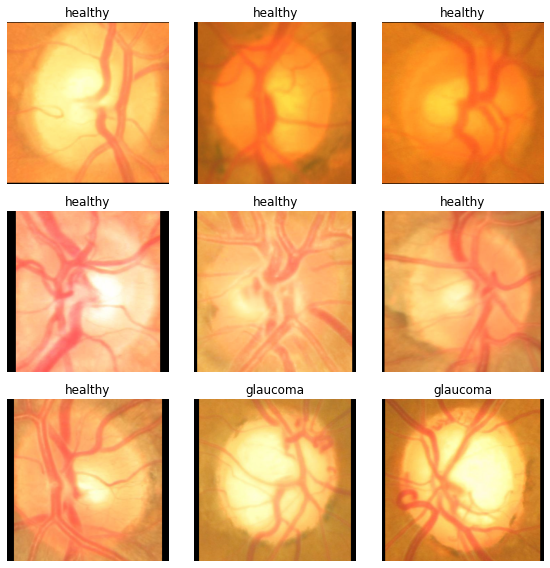

In [44]:
data.show_batch(rows=3, figsize=(8,8))

In [45]:
#Define the two classes
data.classes, data.c

(['glaucoma', 'healthy'], 2)

In [46]:
# Lenght of train dataset
len(data.train_ds)

520

In [47]:
# Lenght of validation dataset
len(data.valid_ds)

129

# Transfer Learning - resnet50

### To save the best model

In [0]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if self.best_acc == None or acc > self.best_acc:
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best accuracy {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Accuracy is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

### Frozen Model

In [0]:
learn = cnn_learner(data, 
                    models.resnet50,       
                    metrics=accuracy)

In [50]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,1.154259,0.688087,0.620155,00:17
1,1.071869,0.698138,0.658915,00:03
2,1.019296,0.819064,0.666667,00:03
3,0.887282,0.839339,0.674419,00:03
4,0.813785,0.739712,0.674419,00:03
5,0.730482,0.852810,0.697674,00:03
6,0.636598,0.752997,0.744186,00:03
7,0.582768,0.693812,0.751938,00:03
8,0.564092,0.761722,0.751938,00:03
9,0.509915,0.711577,0.728682,00:03


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


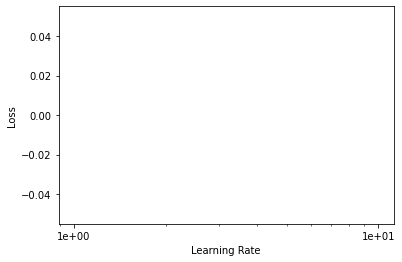

In [51]:
learn.lr_find()
learn.recorder.plot()

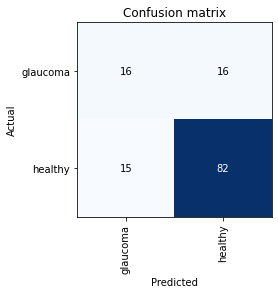

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [53]:
learn.save(path_root,'CNN-Res50-frozen')

FileNotFoundError: ignored

### **Completely Unfrozen**

In [0]:
learn_unfreeze = cnn_learner(data, 
                             models.resnet50,       
                             metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


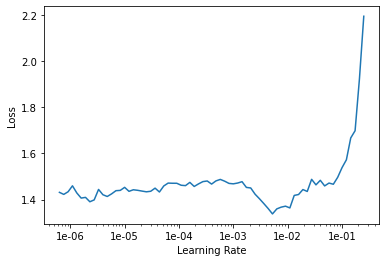

In [56]:
learn_unfreeze.lr_find()
learn_unfreeze.recorder.plot()

In [0]:
learn_unfreeze.unfreeze()

In [58]:
learn_unfreeze.fit_one_cycle(50) 

epoch,train_loss,valid_loss,accuracy,time
0,1.192180,0.675559,0.697674,00:05
1,1.069782,0.753621,0.658915,00:04
2,0.950702,0.692056,0.697674,00:04
3,0.866833,0.692516,0.697674,00:04
4,0.750360,1.263090,0.682171,00:04
5,0.630658,0.763175,0.767442,00:04
6,0.573495,0.897957,0.821705,00:05
7,0.559995,1.524636,0.689922,00:04
8,0.497234,1.058926,0.736434,00:04
9,0.467468,0.924297,0.782946,00:04


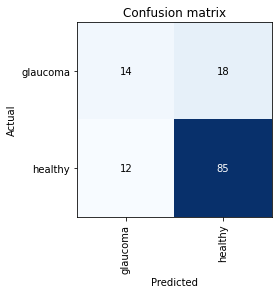

In [59]:
interp = ClassificationInterpretation.from_learner(learn_unfreeze)
interp.plot_confusion_matrix()

In [60]:
learn_unfreeze.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
___________________________________________________

In [61]:
learn_unfreeze.save(path_root,'CNN-Res50-Unfrozen')

FileNotFoundError: ignored

### **Freezing the last two layers (Classifier + last convolutional layer).**



In [0]:
learn = cnn_learner(data, 
                    models.resnet50,       
                    metrics=accuracy,callback_fns=SaveBestModel)

In [63]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [0]:
learn.freeze_to(-2)

In [65]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace=True)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 6

In [66]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,1.287648,0.605343,0.720930,00:04
1,0.960371,0.609997,0.744186,00:04
2,0.880086,0.684654,0.720930,00:04
3,0.805513,0.688752,0.728682,00:04
4,0.713081,0.672485,0.736434,00:04
5,0.627414,0.851354,0.713178,00:04
6,0.650075,0.881229,0.736434,00:04
7,0.559499,0.749428,0.790698,00:04
8,0.471783,0.877504,0.736434,00:04


Save the best accuracy 0.72093
Save the best accuracy 0.74419
Save the best accuracy 0.79070
Save the best accuracy 0.81395
Accuracy is eq,Save the lower loss 0.65418
Save the best accuracy 0.82946
Accuracy is eq,Save the lower loss 0.64460
Save the best accuracy 0.84496


In [67]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
___________________________________________________

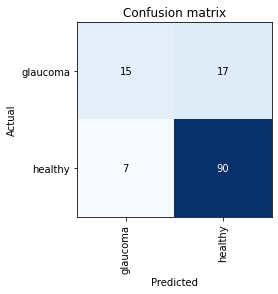

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
import torch
import torch.nn as nn
from torchvision import models

original_model = models.resnet50(pretrained=True)

class ResnetFeature(nn.Module):
            def __init__(self):
                super(ResnetFeature, self).__init__()
                self.features = nn.Sequential(
                    # stop at conv4
                    *list(original_model.children())[:-1]
                   # *list(original_model.features.children())
                )
            def forward(self, x):
                x = self.features(x)
                return x

model = ResnetFeature()

In [0]:
model_dict = model.state_dict()
pretrained_dict = torch.load('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Second Branch/output_rcnn_ORIGA/models/best_model.pth',map_location=torch.device('cpu'))
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict)
# 3. load the new state dict
model.load_state_dict(model_dict)
model.eval()

ResnetFeature(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [0]:
import cv2
from PIL import Image
from torchvision import transforms
def featuremap(path_image):
  print(path_image)
  img = cv2.imread(path_image)
  trans = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
  img = trans(img)
  img = img.unsqueeze(0) 
  output = model(img)
  featuremap = output.squeeze(0)
  return featuremap

### Feature extraction of the whole dataset

In [0]:
# To get the images in the same order than google drive.
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [0]:
images_glaucoma = sorted_alphanumeric(os.listdir(path_glaucoma))
images_healthy = sorted_alphanumeric(os.listdir(path_healthy))

Glaucoma Features

In [0]:
with open('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Second Branch/CNN/feature_extraction_glaucoma.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for name in images_glaucoma:
      writer.writerow(featuremap(str(path_glaucoma)+"/"+name).detach().numpy().tolist())

/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/glaucoma/Glaucoma_roi_resized_1.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/glaucoma/Glaucoma_roi_resized_2.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/glaucoma/Glaucoma_roi_resized_3.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/glaucoma/Glaucoma_roi_resized_4.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/glaucoma/Glaucoma_roi_resized_5.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/glaucoma/Glaucoma_roi_resized_6.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/glaucoma/Glaucoma_roi_resized_7.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/glaucoma/Glaucoma_roi_resized_8.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcn

Healthy Features

In [0]:
with open('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Second Branch/CNN/feature_extraction_healthy.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for name in images_healthy:
      writer.writerow(featuremap(str(path_healthy)+"/"+name).detach().numpy().tolist())

/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/healthy/healthy_roi_resized_13.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/healthy/healthy_roi_resized_14.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/healthy/healthy_roi_resized_15.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/healthy/healthy_roi_resized_16.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/healthy/healthy_roi_resized_17.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/healthy/healthy_roi_resized_18.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/healthy/healthy_roi_resized_19.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/healthy/healthy_roi_resized_20.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn_ORIGA/

# Loading Final Dataset - Feature Extraction

In [0]:
glaucoma_feature_dataset=pd.read_csv("/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Second Branch/CNN/feature_extraction_glaucoma.csv", header=None)

In [0]:
healthy_feature_dataset=pd.read_csv("/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Second Branch/CNN/feature_extraction_healthy.csv", header=None)

In [0]:
glaucoma_feature_dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,[[0.09180658310651779]],[[0.06471298635005951]],[[0.048773009330034256]],[[0.0]],[[0.16148509085178375]],[[0.13265635073184967]],[[0.11467190831899643]],[[0.22338908910751343]],[[0.07476530969142914]],[[0.13331542909145355]],[[0.01591554284095764]],[[0.014340911991894245]],[[0.21116338670253754]],[[0.00283236475661397]],[[0.043442096561193466]],[[0.006896187551319599]],[[0.05716721713542938]],[[0.05554216355085373]],[[0.1599353700876236]],[[0.08109728246927261]],[[0.23645833134651184]],[[0.023335061967372894]],[[0.2948123514652252]],[[0.18982525169849396]],[[0.18618103861808777]],[[0.00953914225101471]],[[0.011529941111803055]],[[0.09438596665859222]],[[0.43865180015563965]],[[0.02729181945323944]],[[0.08428490906953812]],[[0.26319509744644165]],[[0.2803299129009247]],[[0.01299947127699852]],[[0.24398159980773926]],[[0.010864370502531528]],[[0.019262291491031647]],[[0.06518280506134033]],[[0.47361090779304504]],[[0.2565271258354187]],...,[[0.16167694330215454]],[[0.2855895459651947]],[[0.05334555730223656]],[[0.8263120651245117]],[[0.05475272983312607]],[[0.06637398898601532]],[[0.000992053421214223]],[[0.051664989441633224]],[[0.017185237258672714]],[[0.03973008319735527]],[[0.2722945809364319]],[[0.04484471306204796]],[[0.11080753803253174]],[[0.04229395091533661]],[[0.06310246884822845]],[[2.288883686065674]],[[0.4810146391391754]],[[0.21639838814735413]],[[1.260767936706543]],[[0.02635069750249386]],[[0.058701418340206146]],[[0.12163436412811279]],[[0.030613018199801445]],[[0.32989615201950073]],[[0.08291628211736679]],[[0.0978657603263855]],[[0.5812918543815613]],[[0.050297029316425323]],[[0.15711426734924316]],[[0.1530061960220337]],[[0.2963006794452667]],[[0.09538889676332474]],[[0.004564480856060982]],[[0.07010255008935928]],[[0.20601947605609894]],[[0.014816106297075748]],[[0.054408956319093704]],[[0.026667609810829163]],[[0.00714198499917984]],[[0.08837281912565231]]
1,[[0.06188433617353439]],[[0.09207871556282043]],[[0.07950563728809357]],[[0.005471502430737019]],[[0.3178517520427704]],[[0.30473190546035767]],[[0.2847970724105835]],[[0.2056029886007309]],[[0.15781071782112122]],[[0.1149471327662468]],[[0.06430359929800034]],[[0.008783859200775623]],[[0.5521891713142395]],[[0.0]],[[0.09701494127511978]],[[0.037034206092357635]],[[0.10262028127908707]],[[0.19315116107463837]],[[0.26645633578300476]],[[0.12216942012310028]],[[0.5868145823478699]],[[0.031520891934633255]],[[0.4149385988712311]],[[0.2957763075828552]],[[0.28261369466781616]],[[0.020971765741705894]],[[0.024104220792651176]],[[0.05315079540014267]],[[0.2620321214199066]],[[0.11583065986633301]],[[0.43196409940719604]],[[0.2845892310142517]],[[0.16807079315185547]],[[0.1150958463549614]],[[0.25570279359817505]],[[0.02227764204144478]],[[0.07894683629274368]],[[0.06897993385791779]],[[0.43406397104263306]],[[0.5901021361351013]],...,[[0.32378116250038147]],[[0.4105936586856842]],[[0.1252601444721222]],[[0.9117542505264282]],[[0.16264009475708008]],[[0.18781404197216034]],[[0.12034037709236145]],[[0.07598351687192917]],[[0.0933987945318222]],[[0.097571961581707]],[[0.5683012008666992]],[[0.019084932282567024]],[[0.19954818487167358]],[[0.04998081922531128]],[[0.2006128430366516]],[[1.60672128200531]],[[1.191964864730835]],[[0.2657880187034607]],[[1.0178749561309814]],[[0.04828570783138275]],[[0.1276029795408249]],[[0.06453686952590942]],[[0.0037430045194923878]],[[0.1861603856086731]],[[0.1741182804107666]],[[0.013312026858329773]],[[0.6373957991600037]],[[0.07450474798679352]],[[0.31766563653945923]],[[0.21925336122512817]],[[0.4163810610771179]],[[0.11127464473247528]],[[0.006349281407892704]],[[0.1269199699163437]],[[0.5807706117630005]],[[0.07

In [0]:
glaucoma_feature_dataset.shape

(168, 2048)

In [0]:
healthy_feature_dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,[[0.02664174512028694]],[[0.13815057277679443]],[[0.024686217308044434]],[[0.006048734299838543]],[[0.1615356057882309]],[[0.47381114959716797]],[[0.09269198030233383]],[[0.23171716928482056]],[[0.2096232920885086]],[[0.13383212685585022]],[[0.10087653249502182]],[[0.11137403547763824]],[[0.5264134407043457]],[[0.0]],[[0.05510030314326286]],[[0.023210939019918442]],[[0.1451699435710907]],[[0.2686833143234253]],[[0.10938335955142975]],[[0.1669122278690338]],[[0.8250865936279297]],[[0.16900905966758728]],[[0.6116750836372375]],[[0.39694154262542725]],[[0.16751441359519958]],[[0.007285717409104109]],[[0.01850872114300728]],[[0.049258746206760406]],[[0.4443749189376831]],[[0.0820559412240982]],[[0.18736809492111206]],[[0.7003109455108643]],[[0.030942615121603012]],[[0.034090109169483185]],[[0.42606478929519653]],[[0.17994268238544464]],[[0.3797067701816559]],[[0.328975111246109]],[[0.5403517484664917]],[[0.5673704743385315]],...,[[0.12457706034183502]],[[0.31237390637397766]],[[0.3765835762023926]],[[1.3890362977981567]],[[0.009226224385201931]],[[0.05943289399147034]],[[0.2493496537208557]],[[0.14273042976856232]],[[0.14431919157505035]],[[0.09047841280698776]],[[0.47746482491493225]],[[0.004231969825923443]],[[0.6738672852516174]],[[0.0]],[[0.03344568610191345]],[[1.9602646827697754]],[[0.7164714336395264]],[[0.24553261697292328]],[[0.6730825901031494]],[[0.04558718577027321]],[[0.0949450433254242]],[[0.0726836770772934]],[[0.0075034499168396]],[[0.24641677737236023]],[[0.08453524857759476]],[[0.00986334029585123]],[[0.5113824605941772]],[[0.017385093495249748]],[[0.24497021734714508]],[[0.5929655432701111]],[[0.31396862864494324]],[[0.265850692987442]],[[0.01482241228222847]],[[0.3469390273094177]],[[0.2844054102897644]],[[0.11715438216924667]],[[0.03192692995071411]],[[0.3183861970901489]],[[0.21930775046348572]],[[0.19458158314228058]]
1,[[0.007106793113052845]],[[0.38604629039764404]],[[0.002407355234026909]],[[0.007801877334713936]],[[0.17865602672100067]],[[0.3804320991039276]],[[0.036413613706827164]],[[0.28069809079170227]],[[0.3488597571849823]],[[0.3213376998901367]],[[0.1044638603925705]],[[0.1582266390323639]],[[0.3812217712402344]],[[0.041815660893917084]],[[0.021155722439289093]],[[0.0]],[[0.04319724813103676]],[[0.12589725852012634]],[[0.0758848488330841]],[[0.16455483436584473]],[[0.9133937358856201]],[[0.349816232919693]],[[0.45260417461395264]],[[0.12874561548233032]],[[0.6495953798294067]],[[0.03555495664477348]],[[0.0]],[[0.1590510606765747]],[[0.26105865836143494]],[[0.2150718867778778]],[[0.02857123874127865]],[[0.7859205007553101]],[[0.0738285481929779]],[[0.005179883446544409]],[[0.9210381507873535]],[[0.10665860772132874]],[[0.4914723038673401]],[[0.2629348039627075]],[[0.5394356846809387]],[[0.27915680408477783]],...,[[0.04454496130347252]],[[0.898070752620697]],[[0.45931485295295715]],[[1.2231532335281372]],[[0.0]],[[0.010396527126431465]],[[0.046153098344802856]],[[0.3365785777568817]],[[0.24457930028438568]],[[0.005994115956127644]],[[0.612859845161438]],[[0.14294256269931793]],[[0.6040955185890198]],[[0.007233425974845886]],[[0.032359812408685684]],[[1.2192550897598267]],[[0.76993727684021]],[[0.006927644833922386]],[[0.3499045968055725]],[[0.022632144391536713]],[[0.012051167897880077]],[[0.1773034632205963]],[[0.03588501736521721]],[[0.3147662878036499]],[[0.6308018565177917]],[[0.00044808464008383453]],[[0.38459512591362]],[[0.026157725602388382]],[[0.4661869704723358]],[[1.264487862586975]],[[0.7465353608131409]],[[0.11260378360748291]],[[0.04930756986141205]],[[0.5977516174316406]],[[0.4244389832019806]],[[0.1714240163564682]],[[0.007911691442131996]],[[0.5523746609687805]],[[0.53034

In [0]:
healthy_feature_dataset.shape

(469, 2048)